In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 64

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Center loss

In [15]:
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
            
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

## Island loss

In [5]:
class IslandLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, lambd_1, num_classes=7, feat_dim=512, use_gpu=True):
        super(IslandLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu
        self.lambd_1 = lambd_1

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        # center loss
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
            
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        center_loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size
        
        
        # island loss
        center_norm = self.centers.norm(dim=1, keepdim=True)
        norms = 1. / torch.mm(center_norm, center_norm.permute(1,0))
        ones = torch.ones((len(classes), len(classes))).to(self.centers.device)
        diag = torch.ones((len(classes), len(classes))).to(self.centers.device)
        diag.masked_fill_(torch.eye(len(classes), len(classes)).to(self.centers.device).byte(), 0)
        
        cor_sim = torch.bmm(self.centers.permute(1,0).unsqueeze(-1), self.centers.permute(1,0).unsqueeze(1))
        cor_sim = (cor_sim * norms[None, :, :]) + ones[None,:,:] # norm + 1
        cor_sim = cor_sim * diag
        island_loss = cor_sim.sum(dim=1).permute(1,0)
        island_loss = island_loss.clamp(min=1e-12, max=1e+12).sum() / batch_size
        island_loss = center_loss + (self.lambd_1*island_loss)
        
        return center_loss

## Squeeze and excitation

In [12]:
class SamplingDepth(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(SamplingDepth, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout, inplace=False)
        
        # options
#         self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()
        
    def forward(self, x):
        x = self.global_pool(x)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activation(x)
        
        return x
    
class SamplingSize(nn.Module):
    def __init__(self, size, depth):
        super(SamplingSize, self).__init__()
        
        self.size = size
        self.conv1x1 = nn.Conv2d(depth, 1, kernel_size=1, padding=0, stride=1)
        self.fc = nn.Linear(size[0]*size[1], size[0]*size[1])
        
         # options
        # self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()

    def forward(self, x):
        x = self.conv1x1(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        x = self.activation(x)
        
        x = x.reshape(-1, 1, self.size[0], self.size[1])
        
        return x
        
        
MAX_LOGSTD = 10
class SamplingLatentSpace(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingLatentSpace, self).__init__()
        
        
        self.in_size = in_size
        self.out_size = out_size

        self.relu = nn.ReLU()
        
        self.encode_conv = nn.Conv2d(in_size[0], out_size[0], kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.dim = out_size[0] * out_size[1] * out_size[2]
        self.fc_mu = nn.Linear(self.dim, self.dim)
        self.fc_logvar = nn.Linear(self.dim, self.dim)
        
        # self.decode_fc = nn.Linear(dim, fdim)
        # self.decode_conv = nn.ConvTranspose2d(mid_dim, in_size[0], kernel_size=3, padding=1)
        
    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(logvar / 2)
    #     eps = torch.randn_like(std)
        
    #     return mu + std*eps

    def reparameterize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def kl_loss(self, mu, logstd):
        logstd = logstd.clamp(max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))
        
    def forward(self, x):
        
        # encode
        _x = self.encode_conv(x)
        _x = self.relu(_x)

        # _x = self.avgpool(x)
        _x = self.flatten(_x)
        
        x_mu = self.fc_mu(_x)
        x_logvar = self.fc_logvar(_x)
        
        # sampling
        z = self.reparameterize(x_mu, x_logvar)

        # reshape
        z = z.reshape(-1, self.out_size[0], self.out_size[1], self.out_size[2])
        
        return z, self.kl_loss(x_mu, x_logvar)
        
class SamplingAtt(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingAtt, self).__init__()

        self.f_depth = SamplingDepth(in_size[0], out_size[0])
        self.f_spatial = SamplingSize((in_size[1], out_size[1]), out_size[0])
#         self.f_sampling = SamplingLatentSpace(in_size, out_size)

        self.lambd = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        x_depth = self.f_depth(x)
        x_spatial = self.f_spatial(x)

#         z, kl_loss = self.f_sampling(x)
        z = x
#         out = (self.lambd.sigmoid()*(z*x_depth[:,:,None,None])) + ((1 - self.lambd.sigmoid())*(z*x_spatial))
        out = z*x_depth[:,:,None,None] + (z*x_spatial)

#         return out, kl_loss
        return out, 0.0

In [7]:
class pretrainedVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=True)
        
        self.pre_conv = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
        self.block4 = pretrained.features[24:34]
#         self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
        self.att3 = SamplingAtt((256, 8, 8), (256, 8, 8))
        self.att4 = SamplingAtt((512, 4, 4), (512, 4, 4))
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        x, kl3 = self.att3(x)
        
        x = self.block4(x)
        x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x_feature = x.flatten(1)
        x = self.classifier(x_feature)
        
        return x, torch.tensor([kl3, kl4]).sum(), x_feature
        

In [34]:
models.vgg16_bn()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [39]:
class pretrainedResidualVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedResidualVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=True)
        
        self.pre_conv = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.block1a = pretrained.features[:3]
        self.block1b = pretrained.features[3:6]
        
        self.block2a = pretrained.features[7:10]
        self.block2b = pretrained.features[10:13]
        
        self.block3a = pretrained.features[14:17]
        self.block3b = pretrained.features[17:20]
        self.block3c = pretrained.features[20:23]
        
        self.block4a = pretrained.features[24:27]
        self.block4b = pretrained.features[27:30]
        self.block4c = pretrained.features[30:33]
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
        self.att3 = SamplingAtt((256, 8, 8), (256, 8, 8))
        self.att4 = SamplingAtt((512, 4, 4), (512, 4, 4))
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        
        x1 = self.block1a(x)
        x = self.block1b(x1) + x1
        x = self.maxpool(x)
        
        x2 = self.block2a(x)
        x = self.block2b(x2) + x2
        x = self.maxpool(x)
        
        x3 = self.block3a(x)
        x3 = self.block3b(x3) + x3
        x = self.block3c(x3) + x3
        x = self.maxpool(x)
        
        x, kl3 = self.att3(x)
        
        x4 = self.block4a(x)
        x4 = self.block4b(x4) + x4
        x = self.block4c(x4) + x4
        x = self.maxpool(x)
        
        x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x_feature = x.flatten(1)
        x = self.classifier(x_feature)
        
        return x, torch.tensor([kl3, kl4]).sum(), x_feature
        

In [25]:
class pretrainedResnet_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7, pretrained=True):
        
        super(pretrainedResnet_MultiAtt, self).__init__()
        pretrained = models.resnet18(pretrained=pretrained)
        
        self.pre_conv = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.conv1 = pretrained.conv1
        self.bn1 = pretrained.bn1
        self.relu = pretrained.relu
        self.maxpool = pretrained.maxpool
        
        self.layer1 = pretrained.layer1
        self.layer2 = pretrained.layer2
        self.layer3 = pretrained.layer3
        self.layer4 = pretrained.layer4
        
        self.avgpool = pretrained.avgpool
        self.classifier = nn.Linear(512, 7, bias=True)
        
        
        self.att3 = SamplingAtt((256, 4, 4), (256, 4, 4))
        self.att4 = SamplingAtt((512, 2, 2), (512, 2, 2))
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x, kl3 = self.att3(x)
        
        x = self.layer4(x)
#         x, kl4 = self.att4(x)
        
        x = self.avgpool(x)
        x_feature = x.flatten(1)
        x = self.classifier(x_feature)
        
        return x, 0., x_feature
        

In [40]:
pretrainedResnet_MultiAtt()(torch.rand(12, 1, 64, 64))

torch.Size([12, 256, 4, 4])
torch.Size([12, 512, 2, 2])


(tensor([[ 0.7363,  0.5025, -0.1527,  0.3877, -0.3481, -0.5277,  0.1733],
         [-0.2164,  0.4212,  0.4963, -0.3243, -0.4291,  0.3925, -0.7587],
         [-0.6408,  0.9537, -0.4541, -0.7004, -0.7489,  0.5925, -0.1532],
         [-0.7120,  0.4809, -0.1284, -0.1484, -0.0286, -0.2041,  0.0088],
         [-0.3104,  0.2230, -0.2791,  0.3417, -0.1634, -0.1541,  0.3774],
         [-0.1416,  0.0923,  0.2572,  0.4625, -0.2055,  0.2418, -0.4278],
         [-0.7964,  0.6832, -0.0186,  0.7165, -0.7861,  0.5522, -0.0798],
         [-0.2577,  0.6942, -0.1556, -0.3518, -0.0959, -0.3102,  0.1274],
         [ 0.1395,  0.1634, -0.1734, -0.1878, -0.3825,  0.9008, -0.1904],
         [ 0.1343,  0.4874, -0.1913,  0.3847,  0.0175, -0.2053, -0.2523],
         [ 0.4730, -0.0361, -0.0064, -0.0325, -0.0449,  0.3238, -0.5910],
         [ 0.5395,  0.1705, -0.3233,  0.2952, -0.2946,  0.2528, -0.2572]],
        grad_fn=<AddmmBackward>),
 tensor(0.),
 tensor([[0.0000, 0.2424, 0.2025,  ..., 0.0856, 0.0285, 0.5339],

In [8]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()
center_loss = CenterLoss(num_classes=7, feat_dim=512, use_gpu=True)

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)

# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


NameError: name 'CenterLoss' is not defined

In [9]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_centerloss_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss, features = model(inputs)
        loss = criterion(outputs, labels)
        centloss = center_loss(features, labels)
        loss = loss + ((1/len(inputs)) * kl_loss) + (alpha*centloss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        # multiple (1./alpha) in order to remove the effect of alpha on updating centers
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        
        optimizer.step()
        optimizer_centloss.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss, features = model(inputs)
        
        loss = criterion(outputs, labels)
        centloss = center_loss(features, labels)
        loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
Loss=1.5381300449371338 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:33<00:00, 13.55it/s]

- Avg.loss: 6.0936 | Avg.acc: 0.2555


- Avg. val_loss: 1.6052 | Avg. val_acc: 0.3344


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.5534641742706299 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:33<00:00, 13.47it/s]

- Avg.loss: 1.5193 | Avg.acc: 0.3662


- Avg. val_loss: 1.4626 | Avg. val_acc: 0.3661


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.5941529273986816 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:33<00:00, 13.43it/s]

- Avg.loss: 1.3966 | Avg.acc: 0.4391


- Avg. val_loss: 1.3111 | Avg. val_acc: 0.5063


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.3873528242111206 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:33<00:00, 13.48it/s]

- Avg.loss: 1.2369 | Avg.acc: 0.5176


- Avg. val_loss: 1.2365 | Avg. val_acc: 0.5247


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.9777489304542542 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:33<00:00, 13.42it/s]

- Avg.loss: 1.1243 | Avg.acc: 0.5613


- Avg. val_loss: 1.1615 | Avg. val_acc: 0.5531


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.2062593698501587 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:33<00:00, 13.48it/s]

- Avg.loss: 1.0409 | Avg.acc: 0.5962



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2629 | Avg. val_acc: 0.5146
Epoch:  7


Loss=0.8542640805244446 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:33<00:00, 13.46it/s]

- Avg.loss: 0.9827 | Avg.acc: 0.6248


- Avg. val_loss: 1.1077 | Avg. val_acc: 0.5843


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=0.8758665323257446 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:33<00:00, 13.37it/s]

- Avg.loss: 0.9162 | Avg.acc: 0.6498


- Avg. val_loss: 1.1406 | Avg. val_acc: 0.5949


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.0176653861999512 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:33<00:00, 13.47it/s]

- Avg.loss: 0.8477 | Avg.acc: 0.6825


- Avg. val_loss: 1.1461 | Avg. val_acc: 0.5993


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.8562965989112854 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:33<00:00, 13.41it/s]

- Avg.loss: 0.7864 | Avg.acc: 0.7122



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1866 | Avg. val_acc: 0.5974
Epoch:  11


Loss=0.850055456161499 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:33<00:00, 13.40it/s]

- Avg.loss: 0.7319 | Avg.acc: 0.7362


- Avg. val_loss: 1.1923 | Avg. val_acc: 0.6286


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=0.7016300559043884 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:33<00:00, 13.45it/s]

- Avg.loss: 0.6651 | Avg.acc: 0.7661


- Avg. val_loss: 1.2006 | Avg. val_acc: 0.6369


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=0.3710593581199646 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:33<00:00, 13.49it/s]

- Avg.loss: 0.6204 | Avg.acc: 0.7843


- Avg. val_loss: 1.2134 | Avg. val_acc: 0.6386


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.3837185204029083 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.44it/s]

- Avg.loss: 0.5616 | Avg.acc: 0.8065


- Avg. val_loss: 1.2075 | Avg. val_acc: 0.6467


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=0.5143013000488281 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:33<00:00, 13.46it/s]

- Avg.loss: 0.5262 | Avg.acc: 0.8179


- Avg. val_loss: 1.2741 | Avg. val_acc: 0.6553


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.5652281641960144 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:33<00:00, 13.43it/s]

- Avg.loss: 0.4837 | Avg.acc: 0.8340


- Avg. val_loss: 1.2648 | Avg. val_acc: 0.6592


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=0.6772392392158508 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:33<00:00, 13.44it/s]

- Avg.loss: 0.4427 | Avg.acc: 0.8490



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2562 | Avg. val_acc: 0.6548
Epoch:  18


Loss=0.27712661027908325 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.4134 | Avg.acc: 0.8604



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4146 | Avg. val_acc: 0.6517
Epoch:  19


Loss=0.3168026804924011 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.3870 | Avg.acc: 0.8698


- Avg. val_loss: 1.4004 | Avg. val_acc: 0.6609


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.6535789370536804 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:33<00:00, 13.40it/s]

- Avg.loss: 0.3634 | Avg.acc: 0.8797


- Avg. val_loss: 1.3759 | Avg. val_acc: 0.6629


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.30460110306739807 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.44it/s]

- Avg.loss: 0.3420 | Avg.acc: 0.8880



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5509 | Avg. val_acc: 0.6439
Epoch:  22


Loss=0.31017112731933594 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.42it/s]

- Avg.loss: 0.3255 | Avg.acc: 0.8956



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4564 | Avg. val_acc: 0.6514
Epoch:  23


Loss=0.2310371994972229 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.3119 | Avg.acc: 0.8999



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5984 | Avg. val_acc: 0.6425
Epoch:  24


Loss=0.24239400029182434 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.32it/s]

- Avg.loss: 0.2928 | Avg.acc: 0.9070


- Avg. val_loss: 1.5092 | Avg. val_acc: 0.6659


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=0.19548417627811432 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.2816 | Avg.acc: 0.9115


- Avg. val_loss: 1.4877 | Avg. val_acc: 0.6693


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=0.1523331105709076 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.47it/s]

- Avg.loss: 0.2698 | Avg.acc: 0.9147


- Avg. val_loss: 1.4766 | Avg. val_acc: 0.6721


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=0.16692540049552917 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.41it/s]

- Avg.loss: 0.2572 | Avg.acc: 0.9183



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5390 | Avg. val_acc: 0.6643
Epoch:  28


Loss=0.3012140989303589 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:33<00:00, 13.38it/s]

- Avg.loss: 0.2455 | Avg.acc: 0.9240



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5065 | Avg. val_acc: 0.6690
Epoch:  29


Loss=0.2065444141626358 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.2370 | Avg.acc: 0.9252


- Avg. val_loss: 1.6063 | Avg. val_acc: 0.6729


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=0.18490493297576904 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.46it/s]

- Avg.loss: 0.2345 | Avg.acc: 0.9280


- Avg. val_loss: 1.4705 | Avg. val_acc: 0.6826


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=0.19055016338825226 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.48it/s]

- Avg.loss: 0.2234 | Avg.acc: 0.9295



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5599 | Avg. val_acc: 0.6721
Epoch:  32


Loss=0.40195491909980774 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.2204 | Avg.acc: 0.9301



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5281 | Avg. val_acc: 0.6659
Epoch:  33


Loss=0.2203490436077118 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.40it/s]

- Avg.loss: 0.2121 | Avg.acc: 0.9340



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5318 | Avg. val_acc: 0.6676
Epoch:  34


Loss=0.23624713718891144 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.32it/s]

- Avg.loss: 0.2096 | Avg.acc: 0.9358



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5035 | Avg. val_acc: 0.6704
Epoch:  35


Loss=0.23439893126487732 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.31it/s]

- Avg.loss: 0.2021 | Avg.acc: 0.9376



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4801 | Avg. val_acc: 0.6718
Epoch:  36


Loss=0.23040230572223663 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.37it/s]

- Avg.loss: 0.2014 | Avg.acc: 0.9366



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5001 | Avg. val_acc: 0.6732
Epoch    36: reducing learning rate of group 0 to 7.5000e-05.
Epoch:  37


Loss=0.18216581642627716 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.40it/s]

- Avg.loss: 0.1782 | Avg.acc: 0.9448



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5297 | Avg. val_acc: 0.6740
Epoch:  38


Loss=0.19750972092151642 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.35it/s]

- Avg.loss: 0.1606 | Avg.acc: 0.9521



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6732 | Avg. val_acc: 0.6737
Epoch:  39


Loss=0.1767488569021225 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.29it/s]

- Avg.loss: 0.1614 | Avg.acc: 0.9509



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6002 | Avg. val_acc: 0.6693
Epoch:  40


Loss=0.3953946530818939 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.1557 | Avg.acc: 0.9507



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5672 | Avg. val_acc: 0.6771
Epoch:  41


Loss=0.21343578398227692 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.32it/s]

- Avg.loss: 0.1493 | Avg.acc: 0.9551



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6647 | Avg. val_acc: 0.6673
Epoch:  42


Loss=0.478336900472641 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:33<00:00, 13.34it/s]

- Avg.loss: 0.1512 | Avg.acc: 0.9533



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6165 | Avg. val_acc: 0.6723
Epoch    42: reducing learning rate of group 0 to 5.6250e-05.
Epoch:  43


Loss=0.2593386471271515 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.35it/s]

- Avg.loss: 0.1330 | Avg.acc: 0.9603



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6132 | Avg. val_acc: 0.6707
Epoch:  44


Loss=0.07511777430772781 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.38it/s]

- Avg.loss: 0.1194 | Avg.acc: 0.9639



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6288 | Avg. val_acc: 0.6748
Epoch:  45


Loss=0.08045224845409393 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.42it/s]

- Avg.loss: 0.1222 | Avg.acc: 0.9639



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6213 | Avg. val_acc: 0.6790
Epoch:  46


Loss=0.26019585132598877 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.37it/s]

- Avg.loss: 0.1224 | Avg.acc: 0.9630



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6497 | Avg. val_acc: 0.6651
Epoch:  47


Loss=0.2085077464580536 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.35it/s]

- Avg.loss: 0.1147 | Avg.acc: 0.9665



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6517 | Avg. val_acc: 0.6695
Epoch:  48


Loss=0.09215490520000458 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.36it/s]

- Avg.loss: 0.1146 | Avg.acc: 0.9652



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6276 | Avg. val_acc: 0.6695
Epoch    48: reducing learning rate of group 0 to 4.2188e-05.
Epoch:  49


Loss=0.15145064890384674 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.1035 | Avg.acc: 0.9704


- Avg. val_loss: 1.6212 | Avg. val_acc: 0.6832


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  50


Loss=0.11894344538450241 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.45it/s]

- Avg.loss: 0.0995 | Avg.acc: 0.9702



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6412 | Avg. val_acc: 0.6821
Epoch:  51


Loss=0.06766755878925323 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.35it/s]

- Avg.loss: 0.0974 | Avg.acc: 0.9712



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6647 | Avg. val_acc: 0.6812
Epoch:  52


Loss=0.06104552000761032 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.34it/s]

- Avg.loss: 0.0981 | Avg.acc: 0.9710



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6487 | Avg. val_acc: 0.6737
Epoch:  53


Loss=0.21048350632190704 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.34it/s]

- Avg.loss: 0.0901 | Avg.acc: 0.9743



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6785 | Avg. val_acc: 0.6709
Epoch:  54


Loss=0.023620568215847015 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.38it/s]     

- Avg.loss: 0.0916 | Avg.acc: 0.9732



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6590 | Avg. val_acc: 0.6785
Epoch:  55


Loss=0.017069539055228233 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]     

- Avg.loss: 0.0911 | Avg.acc: 0.9739



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6685 | Avg. val_acc: 0.6785
Epoch    55: reducing learning rate of group 0 to 3.1641e-05.
Epoch:  56


Loss=0.12811176478862762 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.36it/s]

- Avg.loss: 0.0804 | Avg.acc: 0.9776



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7028 | Avg. val_acc: 0.6824
Epoch:  57


Loss=0.1825500726699829 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.44it/s]

- Avg.loss: 0.0796 | Avg.acc: 0.9766



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6937 | Avg. val_acc: 0.6812
Epoch:  58


Loss=0.03725755214691162 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.35it/s]      

- Avg.loss: 0.0781 | Avg.acc: 0.9775


- Avg. val_loss: 1.6804 | Avg. val_acc: 0.6835


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  59


Loss=0.029574433341622353 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.41it/s]     

- Avg.loss: 0.0791 | Avg.acc: 0.9784



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6613 | Avg. val_acc: 0.6765
Epoch:  60


Loss=0.016093270853161812 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.41it/s]     

- Avg.loss: 0.0747 | Avg.acc: 0.9788



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6565 | Avg. val_acc: 0.6812
Epoch:  61


Loss=0.14671410620212555 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.35it/s]

- Avg.loss: 0.0752 | Avg.acc: 0.9782


- Avg. val_loss: 1.6846 | Avg. val_acc: 0.6907


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  62


Loss=0.1122279167175293 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.44it/s]

- Avg.loss: 0.0739 | Avg.acc: 0.9788



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6916 | Avg. val_acc: 0.6865
Epoch:  63


Loss=0.017915822565555573 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.38it/s]     

- Avg.loss: 0.0739 | Avg.acc: 0.9795



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6877 | Avg. val_acc: 0.6826
Epoch:  64


Loss=0.22871896624565125 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.0749 | Avg.acc: 0.9782



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7129 | Avg. val_acc: 0.6812
Epoch:  65


Loss=0.09799401462078094 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.44it/s]

- Avg.loss: 0.0729 | Avg.acc: 0.9791



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6715 | Avg. val_acc: 0.6865
Epoch:  66


Loss=0.02300613559782505 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.41it/s]      

- Avg.loss: 0.0729 | Avg.acc: 0.9791



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6979 | Avg. val_acc: 0.6832
Epoch:  67


Loss=0.03396691381931305 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.30it/s]      

- Avg.loss: 0.0684 | Avg.acc: 0.9797



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7033 | Avg. val_acc: 0.6843
Epoch    67: reducing learning rate of group 0 to 2.3730e-05.
Epoch:  68


Loss=0.13207024335861206 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.33it/s]

- Avg.loss: 0.0685 | Avg.acc: 0.9806



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6961 | Avg. val_acc: 0.6829
Epoch:  69


Loss=0.01028131227940321 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.38it/s]      

- Avg.loss: 0.0598 | Avg.acc: 0.9831



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7397 | Avg. val_acc: 0.6849
Epoch:  70


Loss=0.03640269860625267 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.36it/s]      

- Avg.loss: 0.0623 | Avg.acc: 0.9825



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6826 | Avg. val_acc: 0.6877
Epoch:  71


Loss=0.040541209280490875 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.27it/s]     

- Avg.loss: 0.0618 | Avg.acc: 0.9828



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7212 | Avg. val_acc: 0.6854
Epoch:  72


Loss=0.03924255818128586 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.34it/s]

- Avg.loss: 0.0645 | Avg.acc: 0.9824



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7026 | Avg. val_acc: 0.6865
Epoch:  73


Loss=0.03184089809656143 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.37it/s]      

- Avg.loss: 0.0589 | Avg.acc: 0.9836



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7272 | Avg. val_acc: 0.6796
Epoch    73: reducing learning rate of group 0 to 1.7798e-05.
Epoch:  74


Loss=0.012022260576486588 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.37it/s]     

- Avg.loss: 0.0574 | Avg.acc: 0.9834



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7288 | Avg. val_acc: 0.6838
Epoch:  75


Loss=0.08022649586200714 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.33it/s]

- Avg.loss: 0.0575 | Avg.acc: 0.9836



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7189 | Avg. val_acc: 0.6851
Epoch:  76


Loss=0.03557192534208298 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.32it/s]      

- Avg.loss: 0.0514 | Avg.acc: 0.9852



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7407 | Avg. val_acc: 0.6849
Epoch:  77


Loss=0.03656527400016785 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.29it/s]      

- Avg.loss: 0.0529 | Avg.acc: 0.9853



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7344 | Avg. val_acc: 0.6871
Epoch:  78


Loss=0.1267128437757492 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.32it/s]

- Avg.loss: 0.0514 | Avg.acc: 0.9854



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7609 | Avg. val_acc: 0.6860
Epoch:  79


Loss=0.051598966121673584 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.32it/s]

- Avg.loss: 0.0533 | Avg.acc: 0.9848



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7628 | Avg. val_acc: 0.6826
Epoch    79: reducing learning rate of group 0 to 1.3348e-05.
Epoch:  80


Loss=0.01067821029573679 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.37it/s]      

- Avg.loss: 0.0500 | Avg.acc: 0.9857



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7430 | Avg. val_acc: 0.6846
Epoch:  81


Loss=0.018895894289016724 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.30it/s]     

- Avg.loss: 0.0496 | Avg.acc: 0.9861



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7330 | Avg. val_acc: 0.6865
Epoch:  82


Loss=0.023615624755620956 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]     

- Avg.loss: 0.0477 | Avg.acc: 0.9863



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7342 | Avg. val_acc: 0.6863
Epoch:  83


Loss=0.11739635467529297 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.39it/s]

- Avg.loss: 0.0495 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7326 | Avg. val_acc: 0.6851
Epoch:  86


Loss=0.015195215120911598 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.41it/s]     

- Avg.loss: 0.0463 | Avg.acc: 0.9878



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7472 | Avg. val_acc: 0.6865
Epoch:  87


Loss=0.011806044727563858 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.34it/s]     

- Avg.loss: 0.0423 | Avg.acc: 0.9883



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7657 | Avg. val_acc: 0.6879
Epoch:  88


Loss=0.009235932491719723 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.36it/s]     

- Avg.loss: 0.0457 | Avg.acc: 0.9870



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7435 | Avg. val_acc: 0.6871
Epoch:  89


Loss=0.05067797005176544 Batch_id=326 Accuracy=0.984375:  72%|███████▏  | 325/449 [00:24<00:09, 13.52it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.0415741503238678 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.36it/s]

- Avg.loss: 0.0395 | Avg.acc: 0.9897


- Avg. val_loss: 1.7486 | Avg. val_acc: 0.6907
Epoch   100: reducing learning rate of group 0 to 7.5085e-06.
Finished Training


In [21]:
# EVALUATE
model = torch.load('squeeze_excit_model/sqeeuze_excit_centerloss_model.pt')
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, kl_loss, features = model(inputs)

    loss = criterion(outputs, labels)
    centloss = center_loss(features, labels)
    loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 511.3003 | Avg. val_acc: 0.7099


In [8]:

model = torch.load('squeeze_excit_model/sqeeuze_excit_centerloss_model.pt')
device = torch.device('cuda')
alpha = 1
model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# center_loss = CenterLoss(num_classes=7, feat_dim=512, use_gpu=True)

# learning_rate = 0.0001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)

# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_features = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
#     labels = labels.to(device)
    _labels.append(labels.cpu())
    
    with torch.no_grad():
        outputs, kl_loss, features = model(inputs)
    _features.append(features.detach().cpu())

#     loss = criterion(outputs, labels)
#     centloss = center_loss(features, labels)
#     loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
#     acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

#     running_valloss += (loss.item() * inputs.size(0))
#     running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.0000 | Avg. val_acc: 0.0000


In [9]:
features = torch.cat(_features).detach().cpu().numpy()
labels = torch.cat(_labels).cpu().numpy()

In [16]:
label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
str_labels = [label_dict[int(k)] for k in labels]

In [12]:
features.shape, labels.shape

((3589, 512), (3589,))

In [14]:
from sklearn.manifold import TSNE

tsne_features = TSNE(n_components=2).fit_transform(features)

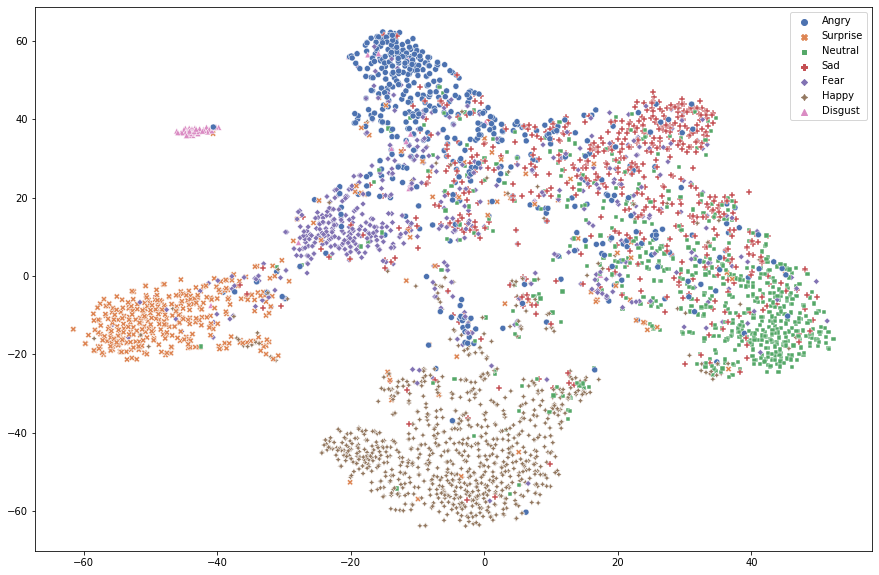

In [17]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], hue=str_labels, style=str_labels, palette="deep")


### Island loss training

In [22]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()
center_loss = IslandLoss(lambd_1=0.1, num_classes=7, feat_dim=512, use_gpu=True)

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)

# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [23]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_islandloss_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss, features = model(inputs)
        loss = criterion(outputs, labels)
        centloss = center_loss(features, labels)
        loss = loss + ((1/len(inputs)) * kl_loss) + (alpha*centloss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        # multiple (1./alpha) in order to remove the effect of alpha on updating centers
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        
        optimizer.step()
        optimizer_centloss.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss, features = model(inputs)
        
        loss = criterion(outputs, labels)
        centloss = center_loss(features, labels)
        loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)
Loss=59.74534606933594 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]

- Avg.loss: 39.7441 | Avg.acc: 0.2502



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7653 | Avg. val_acc: 0.3229
* Update optimal model
Epoch:  2


Loss=59.45550537109375 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:33<00:00, 13.26it/s]

- Avg.loss: 35.1557 | Avg.acc: 0.3632


- Avg. val_loss: 35.6028 | Avg. val_acc: 0.4096


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=59.50249481201172 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:33<00:00, 13.30it/s]

- Avg.loss: 34.9904 | Avg.acc: 0.4562


- Avg. val_loss: 35.4640 | Avg. val_acc: 0.4851


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=59.33230972290039 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:33<00:00, 13.25it/s]

- Avg.loss: 34.8141 | Avg.acc: 0.5380


- Avg. val_loss: 35.3004 | Avg. val_acc: 0.5567


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=59.13266372680664 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]

- Avg.loss: 34.7147 | Avg.acc: 0.5766


- Avg. val_loss: 35.3317 | Avg. val_acc: 0.5628


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=59.02111053466797 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:33<00:00, 13.26it/s]

- Avg.loss: 34.6383 | Avg.acc: 0.6127


- Avg. val_loss: 35.2510 | Avg. val_acc: 0.5968


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=59.11479568481445 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:34<00:00, 13.17it/s]

- Avg.loss: 34.5640 | Avg.acc: 0.6407


- Avg. val_loss: 35.2651 | Avg. val_acc: 0.6041


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=59.280601501464844 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:33<00:00, 13.25it/s]

- Avg.loss: 34.5049 | Avg.acc: 0.6731


- Avg. val_loss: 35.2555 | Avg. val_acc: 0.6049


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=58.642086029052734 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]

- Avg.loss: 34.4274 | Avg.acc: 0.7063


- Avg. val_loss: 35.2745 | Avg. val_acc: 0.6247


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=58.95771789550781 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:33<00:00, 13.27it/s]

- Avg.loss: 34.3700 | Avg.acc: 0.7331


- Avg. val_loss: 35.3565 | Avg. val_acc: 0.6305


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=58.841434478759766 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]

- Avg.loss: 34.3143 | Avg.acc: 0.7587


- Avg. val_loss: 35.3386 | Avg. val_acc: 0.6406


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=58.60041046142578 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:33<00:00, 13.24it/s]

- Avg.loss: 34.2591 | Avg.acc: 0.7816


- Avg. val_loss: 35.3400 | Avg. val_acc: 0.6500


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=58.94953536987305 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]

- Avg.loss: 34.2027 | Avg.acc: 0.7994



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.3928 | Avg. val_acc: 0.6445
Epoch:  14


Loss=58.64894104003906 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]

- Avg.loss: 34.1591 | Avg.acc: 0.8166



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.4721 | Avg. val_acc: 0.6442
Epoch:  15


Loss=58.401123046875 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.28it/s]

- Avg.loss: 34.1152 | Avg.acc: 0.8345


- Avg. val_loss: 35.5051 | Avg. val_acc: 0.6539


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=58.66844177246094 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:34<00:00, 13.15it/s]

- Avg.loss: 34.0765 | Avg.acc: 0.8467


- Avg. val_loss: 35.4811 | Avg. val_acc: 0.6606


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=58.86613845825195 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]

- Avg.loss: 34.0513 | Avg.acc: 0.8573



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.5859 | Avg. val_acc: 0.6525
Epoch:  18


Loss=58.45517349243164 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]

- Avg.loss: 34.0199 | Avg.acc: 0.8697



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.5385 | Avg. val_acc: 0.6606
Epoch:  19


Loss=58.49431610107422 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.24it/s]

- Avg.loss: 33.9935 | Avg.acc: 0.8767


- Avg. val_loss: 35.4803 | Avg. val_acc: 0.6651


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=58.53957748413086 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:34<00:00, 13.14it/s]

- Avg.loss: 33.9661 | Avg.acc: 0.8869


- Avg. val_loss: 35.5369 | Avg. val_acc: 0.6709


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=58.57234191894531 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:34<00:00, 13.17it/s]

- Avg.loss: 33.9543 | Avg.acc: 0.8928



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6029 | Avg. val_acc: 0.6693
Epoch:  22


Loss=58.358856201171875 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.9249 | Avg.acc: 0.9059


- Avg. val_loss: 35.5726 | Avg. val_acc: 0.6765


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=58.73919677734375 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.9164 | Avg.acc: 0.9092


- Avg. val_loss: 35.5509 | Avg. val_acc: 0.6771


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=58.501548767089844 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.9067 | Avg.acc: 0.9110


- Avg. val_loss: 35.6190 | Avg. val_acc: 0.6849


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=58.58989715576172 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]

- Avg.loss: 33.8785 | Avg.acc: 0.9208



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7091 | Avg. val_acc: 0.6701
Epoch:  26


Loss=58.20378112792969 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]

- Avg.loss: 33.8805 | Avg.acc: 0.9203



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6464 | Avg. val_acc: 0.6732
Epoch:  27


Loss=58.30466079711914 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.24it/s]

- Avg.loss: 33.8628 | Avg.acc: 0.9263



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6423 | Avg. val_acc: 0.6773
Epoch:  28


Loss=58.20206069946289 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:34<00:00, 13.14it/s]

- Avg.loss: 33.8551 | Avg.acc: 0.9264



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6698 | Avg. val_acc: 0.6799
Epoch:  29


Loss=58.23767852783203 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]

- Avg.loss: 33.8564 | Avg.acc: 0.9267



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6445 | Avg. val_acc: 0.6779
Epoch:  30


Loss=58.25527572631836 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]

- Avg.loss: 33.8346 | Avg.acc: 0.9348



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6002 | Avg. val_acc: 0.6840
Epoch    30: reducing learning rate of group 0 to 7.5000e-05.
Epoch:  31


Loss=58.35712814331055 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]

- Avg.loss: 33.8089 | Avg.acc: 0.9427



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6381 | Avg. val_acc: 0.6801
Epoch:  32


Loss=58.1988639831543 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.7998 | Avg.acc: 0.9466



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7263 | Avg. val_acc: 0.6743
Epoch:  33


Loss=58.2087287902832 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]

- Avg.loss: 33.7962 | Avg.acc: 0.9479



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6449 | Avg. val_acc: 0.6754
Epoch:  34


Loss=58.46277618408203 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]

- Avg.loss: 33.7873 | Avg.acc: 0.9512


- Avg. val_loss: 35.6658 | Avg. val_acc: 0.6918


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=58.320343017578125 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:34<00:00, 13.10it/s]

- Avg.loss: 33.7865 | Avg.acc: 0.9518



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6427 | Avg. val_acc: 0.6851
Epoch:  36


Loss=58.23236846923828 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.25it/s]

- Avg.loss: 33.7813 | Avg.acc: 0.9525



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6916 | Avg. val_acc: 0.6865
Epoch:  37


Loss=58.28279495239258 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]

- Avg.loss: 33.7764 | Avg.acc: 0.9537


- Avg. val_loss: 35.6162 | Avg. val_acc: 0.6924


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=58.34298324584961 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.7715 | Avg.acc: 0.9560



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6652 | Avg. val_acc: 0.6785
Epoch:  39


Loss=58.235198974609375 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:34<00:00, 13.16it/s]

- Avg.loss: 33.7689 | Avg.acc: 0.9565


- Avg. val_loss: 35.6114 | Avg. val_acc: 0.6932


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=58.24652862548828 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.7660 | Avg.acc: 0.9569



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7142 | Avg. val_acc: 0.6904
Epoch:  41


Loss=58.29306411743164 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]

- Avg.loss: 33.7637 | Avg.acc: 0.9574



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6989 | Avg. val_acc: 0.6824
Epoch:  42


Loss=58.213871002197266 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.7585 | Avg.acc: 0.9584



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7653 | Avg. val_acc: 0.6790
Epoch:  45


Loss=58.30204772949219 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:34<00:00, 13.20it/s]

- Avg.loss: 33.7554 | Avg.acc: 0.9610



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7257 | Avg. val_acc: 0.6865
Epoch    45: reducing learning rate of group 0 to 5.6250e-05.
Epoch:  46


Loss=58.233421325683594 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]

- Avg.loss: 33.7382 | Avg.acc: 0.9677



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.6677 | Avg. val_acc: 0.6907
Epoch:  47


Loss=58.44429016113281 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]

- Avg.loss: 33.7324 | Avg.acc: 0.9677


- Avg. val_loss: 35.7125 | Avg. val_acc: 0.6994


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  48


Loss=58.23054885864258 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]

- Avg.loss: 33.7252 | Avg.acc: 0.9704


- Avg. val_loss: 35.7290 | Avg. val_acc: 0.6996


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  49


Loss=58.29486846923828 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.12it/s]

- Avg.loss: 33.7308 | Avg.acc: 0.9673



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7497 | Avg. val_acc: 0.6860
Epoch:  50


Loss=58.20442581176758 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.20it/s]

- Avg.loss: 33.7270 | Avg.acc: 0.9687



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7178 | Avg. val_acc: 0.6865
Epoch:  51


Loss=58.12704086303711 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.20it/s]      

- Avg.loss: 33.7225 | Avg.acc: 0.9719



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8131 | Avg. val_acc: 0.6840
Epoch:  52


Loss=58.1466178894043 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.12it/s]       

- Avg.loss: 33.7211 | Avg.acc: 0.9710



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7182 | Avg. val_acc: 0.6932
Epoch    54: reducing learning rate of group 0 to 4.2188e-05.
Epoch:  55


Loss=58.138004302978516 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]     

- Avg.loss: 33.7067 | Avg.acc: 0.9755



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7897 | Avg. val_acc: 0.6946
Epoch:  56


Loss=58.22800827026367 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:34<00:00, 13.12it/s]

- Avg.loss: 33.7093 | Avg.acc: 0.9747



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7806 | Avg. val_acc: 0.6932
Epoch:  57


Loss=58.128170013427734 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.17it/s]     

- Avg.loss: 33.7026 | Avg.acc: 0.9761



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7684 | Avg. val_acc: 0.6943
Epoch:  58


Loss=58.13515090942383 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.17it/s]      

- Avg.loss: 33.7067 | Avg.acc: 0.9751



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7713 | Avg. val_acc: 0.6930
Epoch:  59


Loss=58.18094253540039 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]

- Avg.loss: 33.7055 | Avg.acc: 0.9761



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7169 | Avg. val_acc: 0.6946
Epoch:  60


Loss=58.14464569091797 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.7031 | Avg.acc: 0.9768



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7606 | Avg. val_acc: 0.6946
Epoch    60: reducing learning rate of group 0 to 3.1641e-05.
Epoch:  61


Loss=58.14665222167969 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]      

- Avg.loss: 33.6964 | Avg.acc: 0.9786



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7653 | Avg. val_acc: 0.6935
Epoch:  62


Loss=58.22026062011719 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]


- Avg.loss: 33.6942 | Avg.acc: 0.9799


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7495 | Avg. val_acc: 0.6877
Epoch:  63


Loss=58.15052795410156 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]

- Avg.loss: 33.6863 | Avg.acc: 0.9814



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7402 | Avg. val_acc: 0.6941
Epoch:  64


Loss=58.13979721069336 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]      

- Avg.loss: 33.6932 | Avg.acc: 0.9803



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7604 | Avg. val_acc: 0.6949
Epoch:  65


Loss=58.23423385620117 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.26it/s]

- Avg.loss: 33.6892 | Avg.acc: 0.9814



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7549 | Avg. val_acc: 0.6938
Epoch:  66


Loss=58.13041305541992 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.25it/s]      

- Avg.loss: 33.6885 | Avg.acc: 0.9817



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7329 | Avg. val_acc: 0.6985
Epoch    66: reducing learning rate of group 0 to 2.3730e-05.
Epoch:  67


Loss=58.21067428588867 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.25it/s]

- Avg.loss: 33.6830 | Avg.acc: 0.9827



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7729 | Avg. val_acc: 0.6935
Epoch:  68


Loss=58.11832046508789 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]      

- Avg.loss: 33.6827 | Avg.acc: 0.9832



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7689 | Avg. val_acc: 0.6924
Epoch:  69


Loss=58.136680603027344 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.17it/s]     

- Avg.loss: 33.6839 | Avg.acc: 0.9834



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7703 | Avg. val_acc: 0.6977
Epoch:  70


Loss=58.147483825683594 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]     

- Avg.loss: 33.6794 | Avg.acc: 0.9831



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7975 | Avg. val_acc: 0.6943
Epoch:  71


Loss=58.15497589111328 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]      

- Avg.loss: 33.6811 | Avg.acc: 0.9836


- Avg. val_loss: 35.7930 | Avg. val_acc: 0.7002


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  72


Loss=58.13014602661133 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]      

- Avg.loss: 33.6791 | Avg.acc: 0.9843



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7465 | Avg. val_acc: 0.6991
Epoch:  73


Loss=58.130516052246094 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]     

- Avg.loss: 33.6775 | Avg.acc: 0.9847



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7843 | Avg. val_acc: 0.6996
Epoch:  74


Loss=58.12034225463867 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.20it/s]      

- Avg.loss: 33.6781 | Avg.acc: 0.9845


- Avg. val_loss: 35.7921 | Avg. val_acc: 0.7010


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  75


Loss=58.12970733642578 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.24it/s]      

- Avg.loss: 33.6797 | Avg.acc: 0.9834



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7645 | Avg. val_acc: 0.6966
Epoch:  76


Loss=58.327720642089844 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.20it/s]

- Avg.loss: 33.6778 | Avg.acc: 0.9856



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7750 | Avg. val_acc: 0.6957
Epoch:  77


Loss=58.143184661865234 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]     

- Avg.loss: 33.6762 | Avg.acc: 0.9845



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7624 | Avg. val_acc: 0.6999
Epoch:  78


Loss=58.13190841674805 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.17it/s]      

- Avg.loss: 33.6736 | Avg.acc: 0.9850



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7942 | Avg. val_acc: 0.6935
Epoch:  79


Loss=58.23806381225586 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]

- Avg.loss: 33.6752 | Avg.acc: 0.9858



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7945 | Avg. val_acc: 0.6946
Epoch:  80


Loss=58.13764572143555 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]      

- Avg.loss: 33.6754 | Avg.acc: 0.9851



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7714 | Avg. val_acc: 0.6913
Epoch    80: reducing learning rate of group 0 to 1.7798e-05.
Epoch:  81


Loss=58.2166862487793 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.14it/s]

- Avg.loss: 33.6705 | Avg.acc: 0.9864



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8341 | Avg. val_acc: 0.6955
Epoch:  82


Loss=58.13156509399414 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]      

- Avg.loss: 33.6731 | Avg.acc: 0.9862



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7658 | Avg. val_acc: 0.6969
Epoch:  83


Loss=58.117088317871094 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.18it/s]     

- Avg.loss: 33.6670 | Avg.acc: 0.9877


- Avg. val_loss: 35.8006 | Avg. val_acc: 0.7035


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  84


Loss=58.12496566772461 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]      

- Avg.loss: 33.6721 | Avg.acc: 0.9863



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7800 | Avg. val_acc: 0.6991
Epoch:  85


Loss=58.13478469848633 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.15it/s]      

- Avg.loss: 33.6708 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7864 | Avg. val_acc: 0.6994
Epoch:  86


Loss=58.1142578125 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.17it/s]          

- Avg.loss: 33.6697 | Avg.acc: 0.9866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7804 | Avg. val_acc: 0.6977
Epoch:  87


Loss=58.13515853881836 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.22it/s]      

- Avg.loss: 33.6695 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7845 | Avg. val_acc: 0.6966
Epoch:  88


Loss=58.112335205078125 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.25it/s]     

- Avg.loss: 33.6668 | Avg.acc: 0.9879



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8207 | Avg. val_acc: 0.6977
Epoch:  89


Loss=58.21803283691406 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.15it/s]

- Avg.loss: 33.6670 | Avg.acc: 0.9878



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8119 | Avg. val_acc: 0.6949
Epoch    89: reducing learning rate of group 0 to 1.3348e-05.
Epoch:  90


Loss=58.26683044433594 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:34<00:00, 13.17it/s]

- Avg.loss: 33.6663 | Avg.acc: 0.9881



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7991 | Avg. val_acc: 0.6938
Epoch:  91


Loss=58.11063766479492 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.16it/s]      

- Avg.loss: 33.6658 | Avg.acc: 0.9877



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8259 | Avg. val_acc: 0.7005
Epoch:  92


Loss=58.16387939453125 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.16it/s]

- Avg.loss: 33.6646 | Avg.acc: 0.9886



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8002 | Avg. val_acc: 0.6991
Epoch:  93


Loss=58.11309814453125 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]      

- Avg.loss: 33.6646 | Avg.acc: 0.9882



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7950 | Avg. val_acc: 0.6994
Epoch:  94


Loss=58.1929931640625 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]

- Avg.loss: 33.6635 | Avg.acc: 0.9882



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8011 | Avg. val_acc: 0.6977
Epoch:  95


Loss=58.131378173828125 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]     

- Avg.loss: 33.6640 | Avg.acc: 0.9891



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7993 | Avg. val_acc: 0.6946
Epoch    95: reducing learning rate of group 0 to 1.0011e-05.
Epoch:  96


Loss=58.14956283569336 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.23it/s]

- Avg.loss: 33.6624 | Avg.acc: 0.9892



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8005 | Avg. val_acc: 0.6982
Epoch:  97


Loss=58.11994934082031 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]      

- Avg.loss: 33.6608 | Avg.acc: 0.9893



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8139 | Avg. val_acc: 0.6977
Epoch:  98


Loss=58.168601989746094 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:33<00:00, 13.27it/s]

- Avg.loss: 33.6628 | Avg.acc: 0.9889



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.8099 | Avg. val_acc: 0.7005
Epoch:  99


Loss=58.245365142822266 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.14it/s]

- Avg.loss: 33.6640 | Avg.acc: 0.9890



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 35.7790 | Avg. val_acc: 0.6991
Epoch:  100


Loss=58.12360382080078 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:34<00:00, 13.19it/s]      

- Avg.loss: 33.6621 | Avg.acc: 0.9891


- Avg. val_loss: 35.7788 | Avg. val_acc: 0.6980
Finished Training


In [24]:
model = torch.load('squeeze_excit_model/sqeeuze_excit_islandloss_model.pt')
# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, kl_loss, features = model(inputs)

    loss = criterion(outputs, labels)
    centloss = center_loss(features, labels)
    loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


- Avg. val_loss: 35.6263 | Avg. val_acc: 0.7144


In [25]:

model = torch.load('squeeze_excit_model/sqeeuze_excit_islandloss_model.pt')
device = torch.device('cuda')
alpha = 1
model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# center_loss = CenterLoss(num_classes=7, feat_dim=512, use_gpu=True)

# learning_rate = 0.0001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)

# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_features = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
#     labels = labels.to(device)
    _labels.append(labels.cpu())
    
    with torch.no_grad():
        outputs, kl_loss, features = model(inputs)
    _features.append(features.detach().cpu())

#     loss = criterion(outputs, labels)
#     centloss = center_loss(features, labels)
#     loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
#     acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

#     running_valloss += (loss.item() * inputs.size(0))
#     running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.0000 | Avg. val_acc: 0.0000


In [26]:
features = torch.cat(_features).detach().cpu().numpy()
labels = torch.cat(_labels).cpu().numpy()

In [27]:
label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
str_labels = [label_dict[int(k)] for k in labels]

In [28]:
features.shape, labels.shape

((3589, 512), (3589,))

In [29]:
from sklearn.manifold import TSNE

tsne_features = TSNE(n_components=2).fit_transform(features)

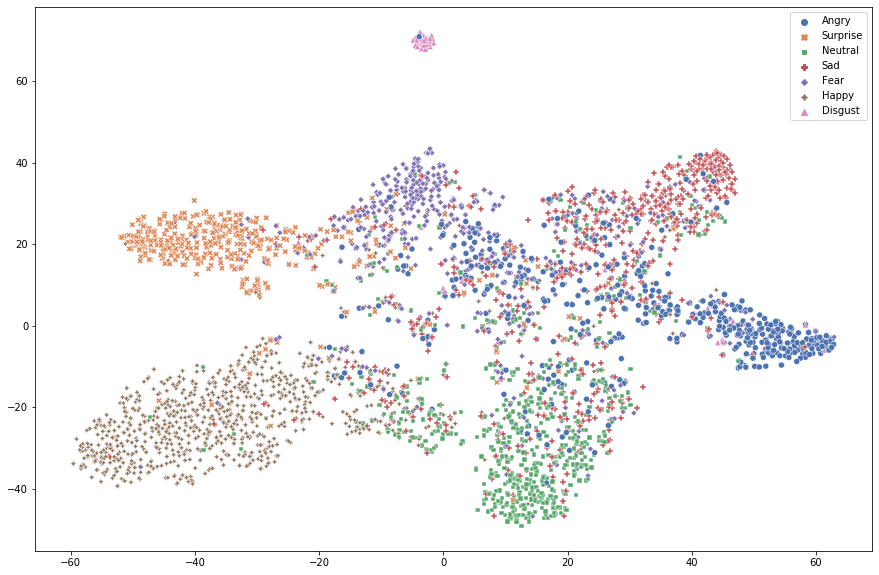

In [30]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], hue=str_labels, style=str_labels, palette="deep")


### Islandloss Resnet18

In [40]:
device = torch.device('cuda')
model = pretrainedResidualVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()
center_loss = IslandLoss(lambd_1=1., num_classes=7, feat_dim=512, use_gpu=True)

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters())
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)

# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [ ]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_islandloss_resVGG_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss, features = model(inputs)
        loss = criterion(outputs, labels)
        centloss = center_loss(features, labels)
        loss = loss + ((1/len(inputs)) * kl_loss) + (alpha*centloss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        # multiple (1./alpha) in order to remove the effect of alpha on updating centers
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        
        optimizer.step()
        optimizer_centloss.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss, features = model(inputs)
        
        loss = criterion(outputs, labels)
        centloss = center_loss(features, labels)
        loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)
Loss=1.7536511421203613 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:33<00:00, 13.21it/s]

- Avg.loss: 5.9849 | Avg.acc: 0.2463



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8142 | Avg. val_acc: 0.2494
* Update optimal model
Epoch:  2


Loss=1.8109067678451538 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:34<00:00, 13.14it/s]

- Avg.loss: 1.8161 | Avg.acc: 0.2512



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8134 | Avg. val_acc: 0.2494
Epoch:  3


Loss=1.7609730958938599 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.07it/s]

- Avg.loss: 1.8119 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8150 | Avg. val_acc: 0.2494
Epoch:  4


Loss=1.782275676727295 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:34<00:00, 13.09it/s]

- Avg.loss: 1.8121 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8137 | Avg. val_acc: 0.2494
Epoch:  5


Loss=1.8627530336380005 Batch_id=448 Accuracy=0.1891891891891892: 100%|██████████| 449/449 [00:34<00:00, 13.09it/s]

- Avg.loss: 1.8119 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8362 | Avg. val_acc: 0.2494
Epoch:  6


Loss=1.8770233392715454 Batch_id=448 Accuracy=0.1891891891891892: 100%|██████████| 449/449 [00:34<00:00, 13.01it/s]

- Avg.loss: 1.8122 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8259 | Avg. val_acc: 0.2494
Epoch:  7


Loss=1.8442009687423706 Batch_id=448 Accuracy=0.10810810810810811: 100%|██████████| 449/449 [00:34<00:00, 13.07it/s]

- Avg.loss: 1.8128 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8351 | Avg. val_acc: 0.2494
Epoch     7: reducing learning rate of group 0 to 7.5000e-04.
Epoch:  8


Loss=1.8484395742416382 Batch_id=448 Accuracy=0.13513513513513514: 100%|██████████| 449/449 [00:34<00:00, 13.03it/s]

- Avg.loss: 1.8112 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8191 | Avg. val_acc: 0.2494
Epoch:  9


Loss=1.7308512926101685 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:34<00:00, 12.99it/s]

- Avg.loss: 1.8115 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8226 | Avg. val_acc: 0.2494
Epoch:  10


Loss=1.7579929828643799 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:34<00:00, 12.99it/s]

- Avg.loss: 1.8118 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8262 | Avg. val_acc: 0.2494
Epoch:  11


Loss=1.8267788887023926 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:34<00:00, 12.99it/s]

- Avg.loss: 1.8144 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8154 | Avg. val_acc: 0.2494
Epoch:  12


Loss=1.9029245376586914 Batch_id=448 Accuracy=0.13513513513513514: 100%|██████████| 449/449 [00:34<00:00, 13.01it/s]

- Avg.loss: 1.8114 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8244 | Avg. val_acc: 0.2494
Epoch:  13


Loss=1.8665574789047241 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:34<00:00, 12.98it/s]

- Avg.loss: 1.8115 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9527 | Avg. val_acc: 0.2494
Epoch    13: reducing learning rate of group 0 to 5.6250e-04.
Epoch:  14


Loss=1.8672312498092651 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:34<00:00, 12.99it/s]

- Avg.loss: 1.8118 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8210 | Avg. val_acc: 0.2494
Epoch:  15


Loss=1.8209092617034912 Batch_id=448 Accuracy=0.16216216216216217: 100%|██████████| 449/449 [00:34<00:00, 12.96it/s]

- Avg.loss: 1.8105 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9505 | Avg. val_acc: 0.2494
Epoch:  16


Loss=1.862740159034729 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:34<00:00, 12.95it/s]


- Avg.loss: 1.8117 | Avg.acc: 0.2513


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8351 | Avg. val_acc: 0.2494
Epoch:  17


Loss=1.7832667827606201 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:34<00:00, 12.95it/s]

- Avg.loss: 1.8114 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8321 | Avg. val_acc: 0.2494
Epoch:  18


Loss=1.7406814098358154 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:34<00:00, 12.95it/s]

- Avg.loss: 1.8111 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8212 | Avg. val_acc: 0.2494
Epoch:  19


Loss=1.861108660697937 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:34<00:00, 12.95it/s]

- Avg.loss: 1.8125 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8183 | Avg. val_acc: 0.2494
Epoch    19: reducing learning rate of group 0 to 4.2188e-04.
Epoch:  20


Loss=1.842922568321228 Batch_id=448 Accuracy=0.1891891891891892: 100%|██████████| 449/449 [00:34<00:00, 12.91it/s]

- Avg.loss: 1.8108 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8187 | Avg. val_acc: 0.2494
Epoch:  21


Loss=1.8238475322723389 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:34<00:00, 12.93it/s]

- Avg.loss: 1.8107 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8208 | Avg. val_acc: 0.2494
Epoch:  22


Loss=1.8706061840057373 Batch_id=448 Accuracy=0.16216216216216217: 100%|██████████| 449/449 [00:34<00:00, 12.90it/s]

- Avg.loss: 1.8109 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8372 | Avg. val_acc: 0.2494
Epoch:  23


Loss=2.0221290588378906 Batch_id=448 Accuracy=0.16216216216216217: 100%|██████████| 449/449 [00:34<00:00, 12.97it/s]

- Avg.loss: 1.8111 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8794 | Avg. val_acc: 0.2494
Epoch:  24


Loss=1.8352689743041992 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:34<00:00, 12.97it/s]

- Avg.loss: 1.8112 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 9.7589 | Avg. val_acc: 0.2494
Epoch:  25


Loss=1.7556551694869995 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:34<00:00, 12.91it/s]


- Avg.loss: 1.8107 | Avg.acc: 0.2513


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8395 | Avg. val_acc: 0.2494
Epoch    25: reducing learning rate of group 0 to 3.1641e-04.
Epoch:  26


Loss=1.7437560558319092 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:34<00:00, 12.91it/s]

- Avg.loss: 1.8104 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8185 | Avg. val_acc: 0.2494
Epoch:  27


Loss=1.8703831434249878 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:34<00:00, 12.91it/s]

- Avg.loss: 1.8107 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8195 | Avg. val_acc: 0.2494
Epoch:  28


Loss=1.7733824253082275 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:34<00:00, 12.97it/s]

- Avg.loss: 1.8106 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8179 | Avg. val_acc: 0.2494
Epoch:  29


Loss=1.8062278032302856 Batch_id=448 Accuracy=0.16216216216216217: 100%|██████████| 449/449 [00:34<00:00, 12.96it/s]

- Avg.loss: 1.8109 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9271 | Avg. val_acc: 0.2494
Epoch:  30


Loss=1.920365571975708 Batch_id=448 Accuracy=0.1891891891891892: 100%|██████████| 449/449 [00:34<00:00, 12.95it/s]

- Avg.loss: 1.8108 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 3.5284 | Avg. val_acc: 0.2494
Epoch:  31


Loss=2.1188852787017822 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:34<00:00, 12.95it/s]


- Avg.loss: 1.8105 | Avg.acc: 0.2513


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8200 | Avg. val_acc: 0.2494
Epoch    31: reducing learning rate of group 0 to 2.3730e-04.
Epoch:  32


Loss=1.8145252466201782 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:34<00:00, 12.95it/s]

- Avg.loss: 1.8103 | Avg.acc: 0.2513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8166 | Avg. val_acc: 0.2494
Epoch:  33


Loss=1.8323090076446533 Batch_id=185 Accuracy=0.296875:  41%|████      | 185/449 [00:14<00:20, 13.16it/s]

In [16]:

model = torch.load('squeeze_excit_model/sqeeuze_excit_islandloss2_model.pt')
device = torch.device('cuda')
alpha = 1
model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# center_loss = CenterLoss(num_classes=7, feat_dim=512, use_gpu=True)

# learning_rate = 0.0001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)

# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_features = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    _labels.append(labels.cpu())
    
    with torch.no_grad():
        outputs, kl_loss, features = model(inputs)
    _features.append(features.detach().cpu())

    loss = criterion(outputs, labels)
    centloss = center_loss(features, labels)
    loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


- Avg. val_loss: 1.5127 | Avg. val_acc: 0.6902


In [17]:
features = torch.cat(_features).detach().cpu().numpy()
labels = torch.cat(_labels).cpu().numpy()

In [18]:
label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
str_labels = [label_dict[int(k)] for k in labels]

In [19]:
features.shape, labels.shape

((3589, 512), (3589,))

In [20]:
from sklearn.manifold import TSNE

tsne_features = TSNE(n_components=2).fit_transform(features)

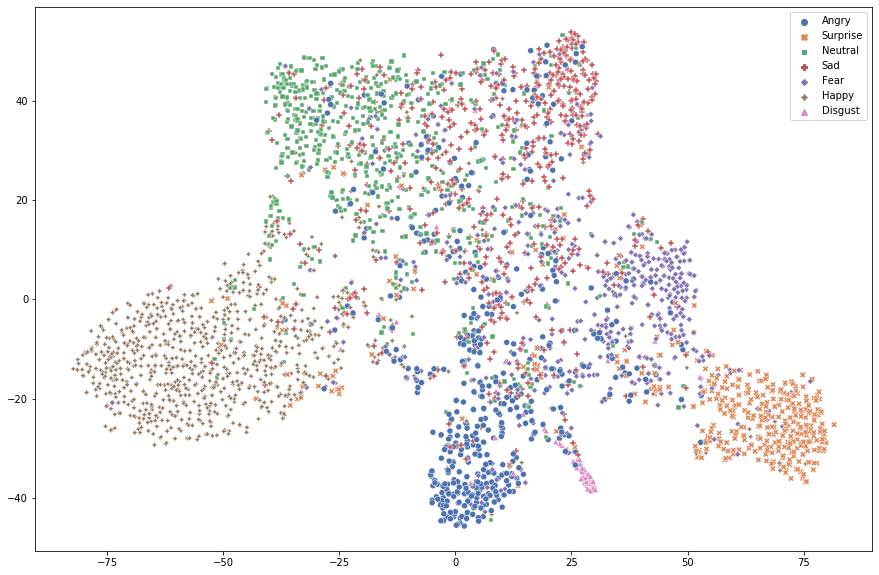

In [21]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], hue=str_labels, style=str_labels, palette="deep")
